<p><small>[PPGCC] Redes Neurais Artificiais &mdash; Prof. Dr. Lucas C. Ribas</small></p>
<p><b><span style="font-size: 1.5rem;">Perceptron</span></b><br>
<small>Rodolfo Viana<br>
26 de março de 2025</small></p>

---

Neste notebook temos uma implementação de perceptron tradicional:

$$
u = \sum_{i=1}^{n}w_{i}x_{i} - \theta \Rightarrow y = g(u)
$$

onde,

- $\{x_1, x_2,..., x_n\}$: entradas
- $\{w_1, w_2,..., w_n\}$: pesos sinápticos
- $\theta$: limiar de ativação
- $y$: saída
- $g(u)$: função de ativação

Note-se: esta implementação só converge corretamente em conjuntos de dados linearmente separáveis. Se os dados não forem linearmente separáveis, o algoritmo poderá não encontrar uma fronteira de decisão adequada ou poderá não convergir.

Como se buscam decisões binárias onde $y \in \{-1, 1\}$, conforme visto em aula e observado nos datasets, utiliza-se o degrau bipolar:

$$
g(u) = \begin{cases}
1, & \text{se}\;u \geq 0, \\
-1, & \text{se}\;u < 0.
\end{cases}
$$

Esse degrau bipolar eleva a correção de erros à magnitude 2 na aplicação da regra de Hebb:

$$
\mathbf{w}_i^{\text{atual}} 
= \mathbf{w}_i^{\text{anterior}} 
  + \eta\bigl(d^{(k)} - y\bigr)\,\mathbf{x}_i^{(k)}.
$$

onde,

- $\mathbf{w}_i$: pesos sinápticos
- $\eta$: taxa de aprendizado
- $d^{(k)}$: saída desejada para a $k$-ésima amostra
- $y$: saída do perceptron
- $\mathbf{x}_i^{(k)}$: valor da entrada $i$ da $k$-ésima amostra de treinamento

Isso ocorre porque:

- se $d = 1$ e $y = -1$, $(d - y) = (1 - (-1)) = 2$
- se $d = -1$ e $y = 1$, $(d - y) = (-1 - 1) = -2$

Se $y \in \{0, 1\}$, a magnitude seria 1:

- se $d = 1$ e $y = 0$, $(d - y) = (1 - 0) = 1$
- se $d = 0$ e $y = 1$, $(d - y) = (0 - 1) = -1$

Por fim, para simplificar a implementação &mdash; e observando as anotações de aula &mdash;, o viés $\theta$ é incorporado ao vetor de pesos, adicionando-se um termo constante $1$ em cada entrada.

In [9]:
import numpy as np
from typing import Tuple, List, Optional, Union

In [11]:
# Implementação
class Perceptron:
    """
    Implementação do perceptron. Inclui viés como parte do vetor de entrada
    (adicionando uma constante 1) e do vetor de pesos.
    """

    def __init__(
        self,
        num_inputs: int,
        learning_rate: float = 0.1,
        random_seed: Optional[int] = None,
    ) -> None:
        """
        Inicializa o perceptron.

        Parâmetros:
            num_inputs: Número de features de entrada (sem contar o bias)
            learning_rate: Taxa de aprendizado para atualização dos pesos
            random_seed (opcional): Semente aleatória para reprodutibilidade
        """
        self.num_inputs = num_inputs
        self.learning_rate = learning_rate

        if random_seed is not None:
            np.random.seed(random_seed)

        self.weights = np.random.uniform(-0.5, 0.5, num_inputs + 1)

    @staticmethod
    def step_activation(z: float) -> int:
        """
        Função degrau bipolar.

        Parâmetros:
            z: Valor de entrada (produto escalar w·x, onde x já inclui o viés)
        """
        return 1 if z >= 0 else -1

    def predict(self, X: Union[List[float], np.ndarray]) -> Union[int, np.ndarray]:
        """
        Prediz a saída para uma única amostra ou um lote de amostras.

        O processo de previsão segue estas etapas:
        1. Adiciona o termo constante 1 para o viés em cada amostra
        2. Calcula z = w·x para cada amostra (onde x já inclui o termo do viés)
        3. Aplica a função degrau

        Parâmetros:
            X: Se for um array 1D, assume-se que é uma única amostra.
               Se for um array 2D, espera-se formato (num_features, num_samples).
        """
        X = np.array(X)
        single_sample = X.ndim == 1

        if (
            single_sample
        ):  # Para uma única amostra: adiciona viés como elemento adicional
            X_with_bias = np.append(X, 1)
            z = np.dot(self.weights, X_with_bias)
            return self.step_activation(z)
        else:  # Para múltiplas amostras: adiciona viés como linha adicional
            num_samples = X.shape[1]
            X_with_bias = np.vstack([X, np.ones(num_samples)])
            z = np.array(
                [np.dot(self.weights, X_with_bias[:, i]) for i in range(num_samples)]
            )
            return np.array([self.step_activation(val) for val in z])

    def fit(
        self,
        X_train: Union[List[List[float]], np.ndarray],
        y_train: Union[List[int], np.ndarray],
        epochs: int = 100,
    ) -> Tuple[np.ndarray, int, List[float]]:
        """
        Treina o modelo conforme a regra de aprendizado do perceptron.

        Parâmetros:
            X_train: Dados de treinamento, array de formato (num_features, num_samples)
            y_train: Rótulos, array de formato (1, num_samples)
            epochs: Número máximo de épocas
        """
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        if (
            X_train.ndim == 2 and y_train.ndim == 2
        ):  # Verifica se os dados estão no formato transposto (features como linhas, amostras como colunas)
            num_samples = X_train.shape[1]
        else:
            raise ValueError(
                "Os dados de entrada devem estar no formato (num_features, num_samples) e (1, num_samples)"
            )

        X_with_bias = np.vstack([X_train, np.ones(num_samples)])

        error_history = (
            []
        )  # Lista para armazenar o erro em cada época. como pedido no enunciado da atividade

        for epoch in range(epochs):
            misclassified = 0

            for i in range(num_samples):
                x_i = X_with_bias[:, i]
                y_i = y_train[0, i]

                z = np.dot(self.weights, x_i)
                y_pred = self.step_activation(z)

                error = y_i - y_pred

                if error != 0:
                    self.weights = self.weights + self.learning_rate * error * x_i
                    misclassified += 1

            error_rate = misclassified / num_samples
            error_history.append(error_rate)

            print(f"Época {epoch+1}/{epochs}, Taxa de erro: {error_rate:.4f}")

            if (
                misclassified == 0
            ):  # Se todas as amostras foram classificadas corretamente, podemos parar
                print(f"Convergência atingida na época {epoch+1}")
                return self.weights, epoch + 1, error_history

        return self.weights, epochs, error_history

    def score(
        self, X: Union[List[List[float]], np.ndarray], y: Union[List[int], np.ndarray]
    ) -> float:
        """
        Calcula a acurácia em um determinado conjunto de dados, sendo:

        acurácia = número_de_previsões_corretas / número_total_de_amostras

        Parâmetros:
            X: Dados de entrada no formato (num_features, num_samples)
            y: Rótulos verdadeiros no formato (1, num_samples)
        """
        preds = self.predict(X)
        y = np.array(y)

        if (
            y.ndim == 2 and y.shape[0] == 1
        ):  # Verifica se y tem o formato esperado (1, num_samples)
            true_labels = y[0]
        else:
            true_labels = y

        correct = np.sum(preds == true_labels)
        return float(correct / len(true_labels))

    def __repr__(self) -> str:
        """
        Retorna uma representação em string do perceptron.
        """
        return f"Perceptron(weights={self.weights}, learning_rate={self.learning_rate})"


### Dataset 1

In [21]:
# Aplicação

import pandas as pd
import matplotlib.pyplot as plt

df_train_loaded = pd.read_csv("train_dataset1.csv")
df_test_loaded = pd.read_csv("test_dataset1.csv")
X_train = df_train_loaded.drop("label", axis=1).values.T # (n_features, n_amostras)
y_train = df_train_loaded["label"].values.reshape(1, -1) # (1, n_amostras)
X_test = df_test_loaded.drop("label", axis=1).values.T
y_test = df_test_loaded["label"].values.reshape(1, -1)

model = Perceptron(num_inputs=X_train.shape[0], learning_rate=0.1, random_seed=42)

In [22]:
pesos_finais, epocas_executadas, historico_erro = model.fit(X_train, y_train, epochs=100)
acuracia_treino = model.score(X_train, y_train)   
acuracia_teste = model.score(X_test, y_test)

print("Pesos finais:", pesos_finais)
print("Épocas executadas:", epocas_executadas)
print("Acurácia no conjunto de treino:", acuracia_treino)
print("Acurácia no conjunto de teste:", acuracia_teste)

Época 1/100, Taxa de erro: 0.0857
Época 2/100, Taxa de erro: 0.0429
Época 3/100, Taxa de erro: 0.0714
Época 4/100, Taxa de erro: 0.0643
Época 5/100, Taxa de erro: 0.0357
Época 6/100, Taxa de erro: 0.0357
Época 7/100, Taxa de erro: 0.0286
Época 8/100, Taxa de erro: 0.0643
Época 9/100, Taxa de erro: 0.0357
Época 10/100, Taxa de erro: 0.0500
Época 11/100, Taxa de erro: 0.0357
Época 12/100, Taxa de erro: 0.0429
Época 13/100, Taxa de erro: 0.0214
Época 14/100, Taxa de erro: 0.0286
Época 15/100, Taxa de erro: 0.0714
Época 16/100, Taxa de erro: 0.0214
Época 17/100, Taxa de erro: 0.0286
Época 18/100, Taxa de erro: 0.0214
Época 19/100, Taxa de erro: 0.0429
Época 20/100, Taxa de erro: 0.0357
Época 21/100, Taxa de erro: 0.0429
Época 22/100, Taxa de erro: 0.0214
Época 23/100, Taxa de erro: 0.0429
Época 24/100, Taxa de erro: 0.0786
Época 25/100, Taxa de erro: 0.0571
Época 26/100, Taxa de erro: 0.0214
Época 27/100, Taxa de erro: 0.0500
Época 28/100, Taxa de erro: 0.0286
Época 29/100, Taxa de erro: 0

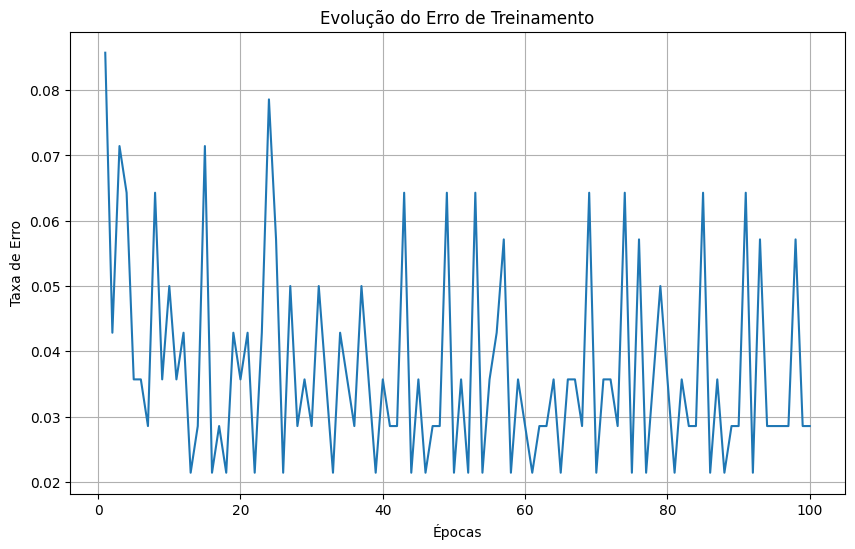

In [23]:
# Gráfico da evolução do erro de treinamento em função das épocas
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(historico_erro) + 1), historico_erro)
plt.title('Evolução do Erro de Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Taxa de Erro')
plt.grid(True)
plt.show()

In [24]:
#Função para plotar os dados e a fronteira de decisão
def plot_decision_boundary(X, y, weights, title):
    X = X.T  # Transforma para (n_amostras, n_features)
    y = y.reshape(-1)  # Transforma para (n_amostras,)
    
    plt.figure(figsize=(10, 8))
    
    idx_neg = y == -1
    idx_pos = y == 1
    
    plt.scatter(X[idx_neg, 0], X[idx_neg, 1], color='red', label='Classe -1')
    plt.scatter(X[idx_pos, 0], X[idx_pos, 1], color='blue', label='Classe 1')
    
    x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x0_range = np.linspace(x0_min, x0_max, 100)
    
    x1_decision = [(-weights[0] * x - weights[2]) / weights[1] for x in x0_range]
    
    plt.plot(x0_range, x1_decision, 'g-', linewidth=2, label='Fronteira de Decisão')
    
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True)
    plt.show()


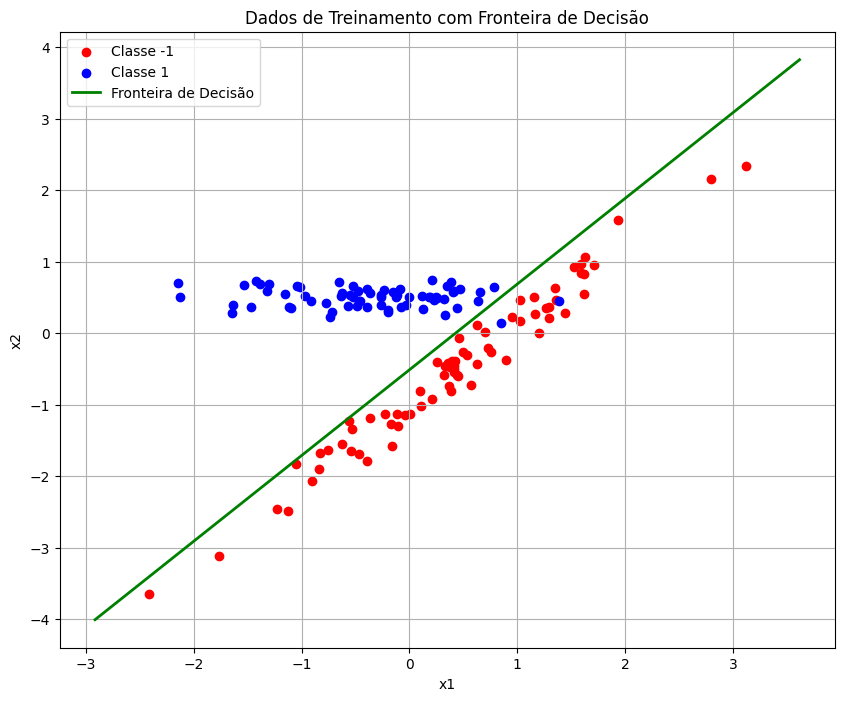

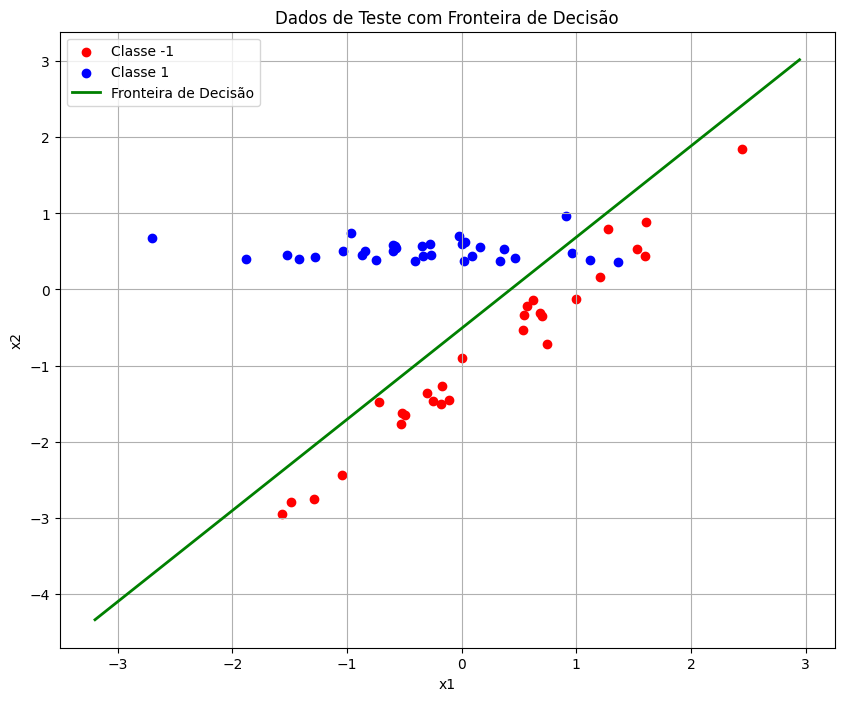

In [25]:
plot_decision_boundary(X_train, y_train, pesos_finais, 
                      'Dados de Treinamento com Fronteira de Decisão')
plot_decision_boundary(X_test, y_test, pesos_finais,
                      'Dados de Teste com Fronteira de Decisão')

### Dataset 2

In [26]:
df_train_loaded = pd.read_csv("train_dataset2.csv")
df_test_loaded = pd.read_csv("test_dataset2.csv")
X_train = df_train_loaded.drop("label", axis=1).values.T # (n_features, n_amostras)
y_train = df_train_loaded["label"].values.reshape(1, -1) # (1, n_amostras)
X_test = df_test_loaded.drop("label", axis=1).values.T
y_test = df_test_loaded["label"].values.reshape(1, -1)

model = Perceptron(num_inputs=X_train.shape[0], learning_rate=0.1, random_seed=42)

In [27]:
pesos_finais, epocas_executadas, historico_erro = model.fit(X_train, y_train, epochs=100)
acuracia_treino = model.score(X_train, y_train)   
acuracia_teste = model.score(X_test, y_test)

print("Pesos finais:", pesos_finais)
print("Épocas executadas:", epocas_executadas)
print("Acurácia no conjunto de treino:", acuracia_treino)
print("Acurácia no conjunto de teste:", acuracia_teste)

Época 1/100, Taxa de erro: 0.4629
Época 2/100, Taxa de erro: 0.4686
Época 3/100, Taxa de erro: 0.4343
Época 4/100, Taxa de erro: 0.4686
Época 5/100, Taxa de erro: 0.4343
Época 6/100, Taxa de erro: 0.4571
Época 7/100, Taxa de erro: 0.4457
Época 8/100, Taxa de erro: 0.4686
Época 9/100, Taxa de erro: 0.4343
Época 10/100, Taxa de erro: 0.4343
Época 11/100, Taxa de erro: 0.4114
Época 12/100, Taxa de erro: 0.4800
Época 13/100, Taxa de erro: 0.4686
Época 14/100, Taxa de erro: 0.4914
Época 15/100, Taxa de erro: 0.4229
Época 16/100, Taxa de erro: 0.4114
Época 17/100, Taxa de erro: 0.4343
Época 18/100, Taxa de erro: 0.4686
Época 19/100, Taxa de erro: 0.4914
Época 20/100, Taxa de erro: 0.4114
Época 21/100, Taxa de erro: 0.4343
Época 22/100, Taxa de erro: 0.4457
Época 23/100, Taxa de erro: 0.4343
Época 24/100, Taxa de erro: 0.4000
Época 25/100, Taxa de erro: 0.4571
Época 26/100, Taxa de erro: 0.4686
Época 27/100, Taxa de erro: 0.4457
Época 28/100, Taxa de erro: 0.4343
Época 29/100, Taxa de erro: 0

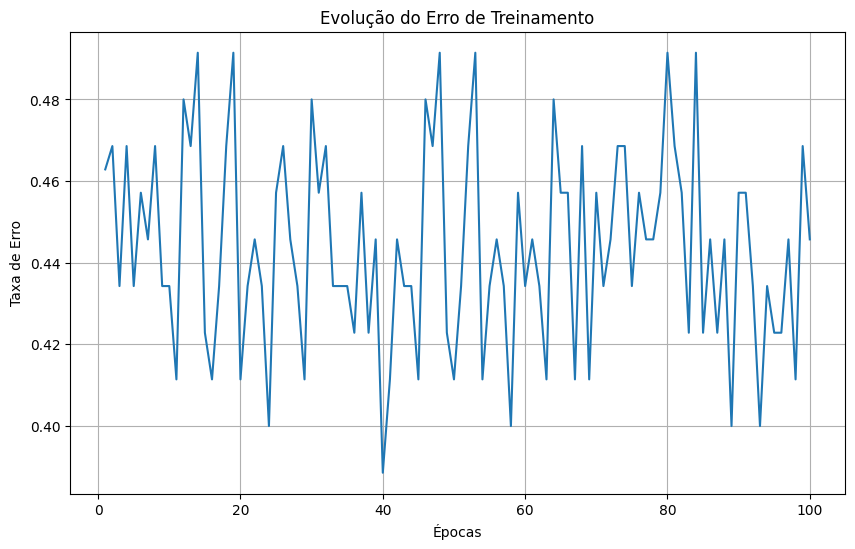

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(historico_erro) + 1), historico_erro)
plt.title('Evolução do Erro de Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Taxa de Erro')
plt.grid(True)
plt.show()

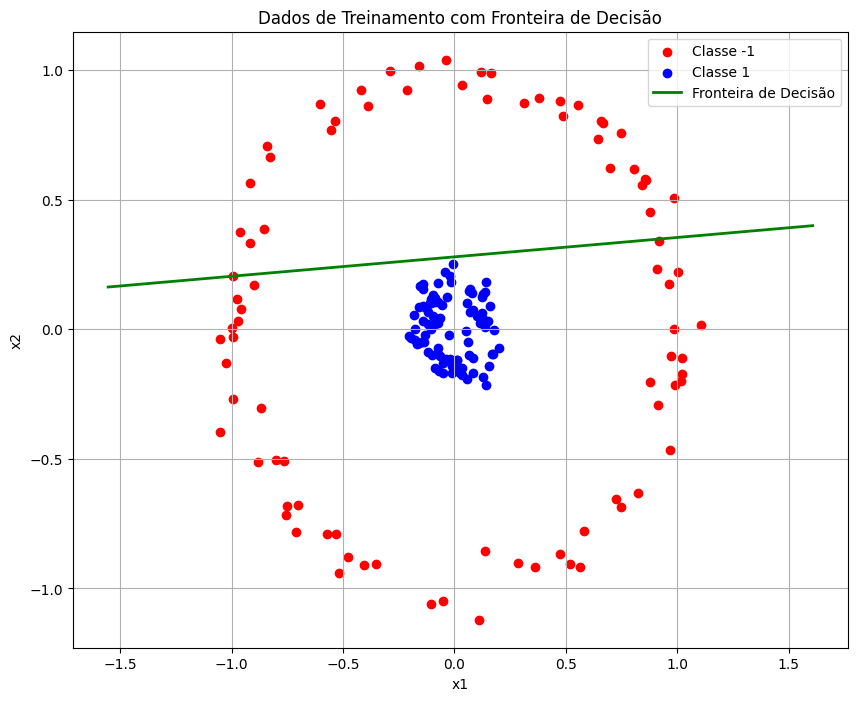

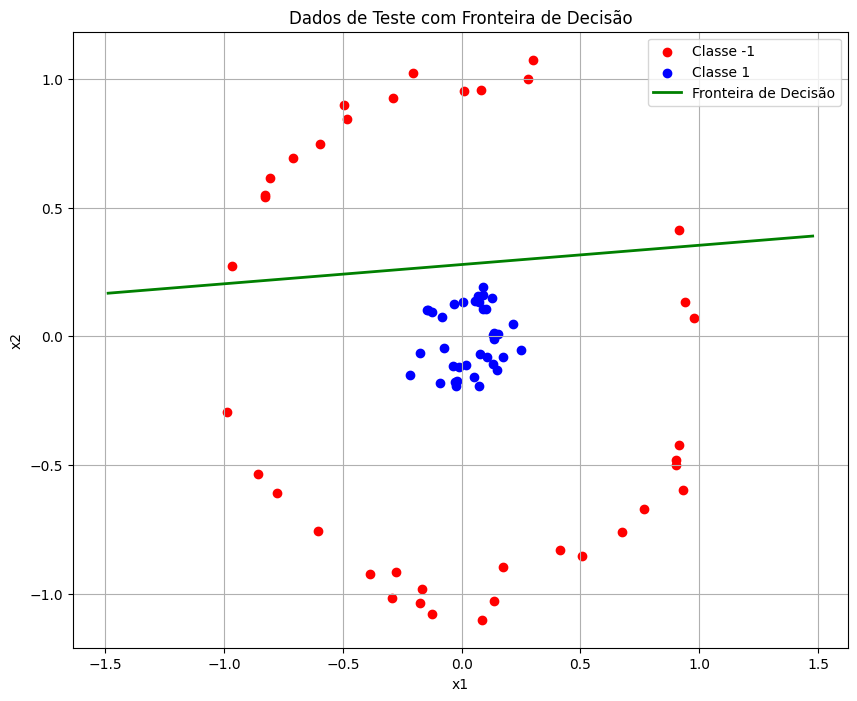

In [29]:
plot_decision_boundary(X_train, y_train, pesos_finais, 
                      'Dados de Treinamento com Fronteira de Decisão')
plot_decision_boundary(X_test, y_test, pesos_finais,
                      'Dados de Teste com Fronteira de Decisão')